# Modelos jerárquicos Bayesianos

Los modelos jerárquicos Bayesianos también conocidos como modelos Bayesianos multi-nivel son modelos estadísticos Bayesianos paramétricos y probabilistas en los cuales los parámetros se estructuran en diversos niveles o jerarquías. En otras palabras, suponiendo que la distribución posterior puede describirse como 

$$
p_A(\alpha,\beta|D) \sim \mathcal{L}(D|\alpha,\beta)p_0(\alpha,\beta|H_{\alpha},H_{\beta})
$$

con $\alpha$ y $\beta$ parámetros de la verosimilitud y del prior $p_0$ el cual tiene hiperparámetros $H_{\alpha}$ y $H_{\beta}$. 

En un modelo jerárquico, los parámetros del prior de nivel cero, $p_0$, se describen como variables aleatorias del prior de nivel uno, $p_1$, el cual puede ser conjunto o independiente. Por ejemplo, 

$$
p_B(\alpha,\beta,\gamma,\eta|D) \sim \mathcal{L}(D|\alpha,\beta)p_0(\alpha,\beta|\gamma,\eta)p_1(\gamma,\eta|H_{\gamma},H_{\eta})
$$

donde ahora los parámetros $\gamma$ y $\eta$ sólo son parámetros de los dos niveles del prior ($p_0$ y $p_1$), es decir, la verosimilitud es independiente de ellos.

## Ventajas
Los MJB permiten disminuir la sensibilidad de la distribución posterior a los valores específicos de los hiperparámetros $H_\alpha$ y $H_\beta$ escogidos en el modelo uní-nivel $p_A$. En otras palabras ayudan a reducir la influencia del investigador al escoger un conjunto de valores para los hiperparámetros del modelo uní-nivel (i.e. $H_{\alpha}$ y $H_{\beta}$) al convertirlos en parámetros del modelo multi-nivel, los cuales se infieren a partir de los datos. Sin embargo, el investigador no escapa a la decisión de elegir la familia de distribuciones para el prior ($p_0$ y $p_1$).

## Desventajas
Al incluir más parámetros en el modelo es necesario más poder de computo o más tiempo de calculo.

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import string

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Ejemplos
Vamos a ver algunos ejemplos de modelos jerárquicos y después intentaremos resolver alguno de los ejercicios de inferencia Bayesiana utilizando los modelos jerárquicos.

## Modelo de las ocho escuelas.

El problema de las ocho escuelas se encuentra descrito en la Sección 5.5 de [Bayesian Data Analysis 3 (Gelman et al.)](http://www.stat.columbia.edu/~gelman/book/BDA3.pdf)

Este estudio fue hecho por el Servicio de Exámenes Educativos (ETS por sus siglas en inglés) para analizar los efectos que tuvo un programa especial de acompañamiento a estudiantes en los resultados de sus exámenes. Experimentos separados y aleatorios fueron realizados para estimar los efectos del programa en las notas del SAT-V (Test Escolástico de Aptitud Verbal) en las ocho escalas. Los resultados fueron las notas que variaban entre 200 y 800 con media 500 y desviación estándar de 100. El test fue específicamente diseñado para evitar la influencia de efectos de corto plazo dedicados simplemente a mejorar los resultados del test, y por lo tanto permiten analizar el conocimiento adquirido y las habilidades aprendidas a lo largo de muchos año de educación.
Cada una de las ocho escuelas consideró que el programa especial de acompañamiento fue efectivo al mejorar los resultados del test. Sin embargo, no hay ninguna información a priori para creer que ninguno de los ocho programas fuese más efectivo ni que algunos fueran tan efectivos como otros. 

Todos los estudiantes del experimento habían realizado el test SAT preliminar tanto el de matemáticas (PSAT-M) como el verbal  (PSAT-V). En cada escuela el efecto del acompañamiento especial y su desviación estándar se obtuvieron con un análisis de covarianza ajustada. Es decir, una regresión lineal se aplico a los resultados del SAT-V del grupo de tratamiento utilizando como variables de control los resultados del PSAT-M y PSAT-V. 

Los valores $y$ se obtuvieron de manera independiente para cada escuela y están distribuidos de manera normal aproximadamente con varianza muestral conocida ya que para todo fin práctico el tamaño muestral es conocido en todas las escuelas y es relativamente grande, con más de treinta estudiantes por escuela.

Los resultados son los siguientes:


In [2]:

df = pd.DataFrame(data={
    "y":np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.]),
    "sd":np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
    },index=list(string.ascii_uppercase[0:8]))

df

,y,sd
A,28.0,15.0
B,8.0,10.0
C,-3.0,16.0
D,7.0,11.0
E,-1.0,9.0
F,1.0,11.0
G,18.0,10.0
H,12.0,18.0


## Inferencias no jerárquicas

### Estimaciones independientes
Mirando los valores de cada escuela, hay resultados muy distintos. Por un lado la escuela A tiene una estimación muy grande del efecto, mientras que por otro lado las escuelas C y E tienen valores negativos. Sin embargo, tomando en cuenta la incertidumbre, las estimaciones independientes nos dicen que los resultados son compatibles dentro de 2$\sigma$ (i.e. 95%). 

Para ver lo anterior pintemos las distribuciones.

/home/jolivares/anaconda3/envs/ceura/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jolivares/anaconda3/envs/ceura/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jolivares/anaconda3/envs/ceura/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jolivares/anaconda3/envs/ceura/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decoration

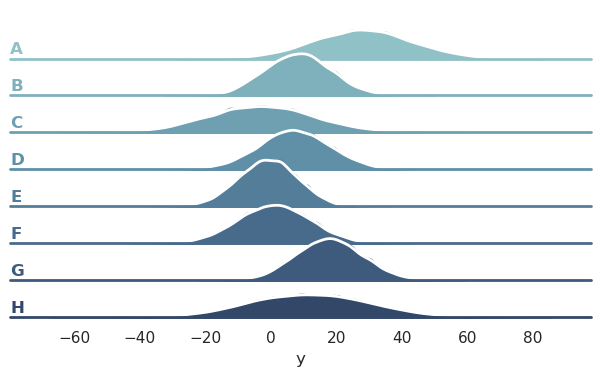

In [3]:
#-------------- Muestras de cada escuela --------------
dfs = []
for idx,(y,sd) in df.iterrows():
    dfs.append(pd.DataFrame(
        data={
        "y":np.random.normal(loc=y,scale=sd,size=10000),
        "escuela":str(idx)
        }))
dfs = pd.concat(dfs,ignore_index=True)
#-------------------------------------------------------

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(dfs, row="escuela", hue="escuela", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "y",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "y", clip_on=False, color="w", lw=2)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "y")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
    

### Estimación conjunta
El hecho de que las estimaciones independientes se sobrepongan podría indicar que los experimentos independientes están estimando la misma cantidad.

Suponiendo que todos los experimentos tienen el mismo efecto y que producen estimaciones independientes de este efecto en común, podemos tomar los datos como ocho estimaciones normales con desviación estándar conocida. 

Así, su media y desviación estándar estarán dadas por

$$
\mu = \frac{\Sigma_i^n \frac{\mu_i}{\sigma_i^2}}{\Sigma_i^n\frac{1}{\sigma_i^2}}
$$

$$
\sigma^2 = \frac{1}{\Sigma_i^n\frac{1}{\sigma_i^2}}
$$

mejor conocidos como media y desviación estándar pesadas, donde los pesos son los inversos de las varianzas.

In [4]:
df["weight"] = df.apply(lambda x:x["sd"]**(-2),axis=1)
sd = np.sqrt(1/np.sum(df["weight"]))
mu = df.apply(lambda x:x["y"]*x["weight"],axis=1).sum()/df["weight"].sum()
print("Media y desviación estándar pesadas: {0:1.2f}, {1:1.2f}".format(mu,sd))
print("El efecto de la escuela A esta a {0:1.1f} desviaciones estandar de la media pesada.".format(
    (df.loc["A","y"]-mu)/sd))

Media y desviación estándar pesadas: 7.69, 4.07
El efecto de la escuela A esta a 5.0 desviaciones estandar de la media pesada.


El resultado muestra que es altamente improbable que la escuela A tenga un efecto de 28 ya que se encuentra a 5$\sigma$.

Como podemos observar, ni las estimaciones independientes ni la conjunta nos dan un resultado satisfactorio. 

***Queremos un resultado que combine la información de todas las escuelas sin suponer que todas ellas son iguales.***

Los MJB ofrecen la solución que buscamos.

### Modelo jerárquico Bayesiano

Vamos a construir un modelo jerárquico suponiendo que cada escuela tiene una media verdadera $\theta_i$ que viene muestreada de una distribución normal con media $\mu$ y desviación estándar $\tau$. Es decir cada $\theta_i$ será una variable estocástica cuyos padres serán $\mu$ y $\tau$. Como prior para $\mu$ utilizaremos una distribución normal y para $\tau$ un Half-Cauchy. En este ultimo caso utilizamos la Half-Cauchy por que $\tau$ siendo una desviación estándar sólo puede tomar valores positivos.

In [5]:
coords = {"escuela": list(string.ascii_uppercase[0:8])}
centered_eight = pm.Model(coords=coords)

with centered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sigma=tau, dims="escuela")
    effect = pm.Normal('effect', mu=theta, sigma=df["sd"], observed=df["y"],dims="escuela")

Para mayor claridad, pintamos el modelo gráfico probabilista.

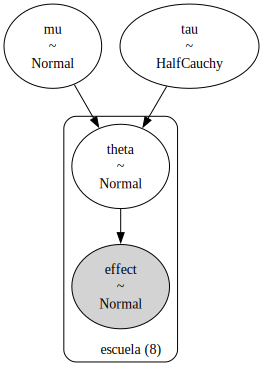

In [6]:
pm.model_to_graphviz(centered_eight)

Hacemos la inferencia de la distribución posterior utilizando los parámetros por defecto de PyMC.

In [7]:
with centered_eight:
    # draw 1000 posterior samples
    samples = pm.sample() # draws=1000, tune=1000,cores=None (default in the system)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.


Observamos varias advertencias que indican muchas divergencias. Sigamos las indicaciones paso a paso.

In [8]:
with centered_eight:
    # draw 1000 posterior samples
    samples = pm.sample(tune=1000,draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.


PyMC nos pide aumentar el "target_accept" o reparametrizar. Aumentemos el target_accept al máximo.

In [9]:
with centered_eight:
    # draw 1000 posterior samples
    samples = pm.sample(tune=1000,draws=2000,target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.


Aún así seguimos teniendo problemas. Veamos las cadenas.

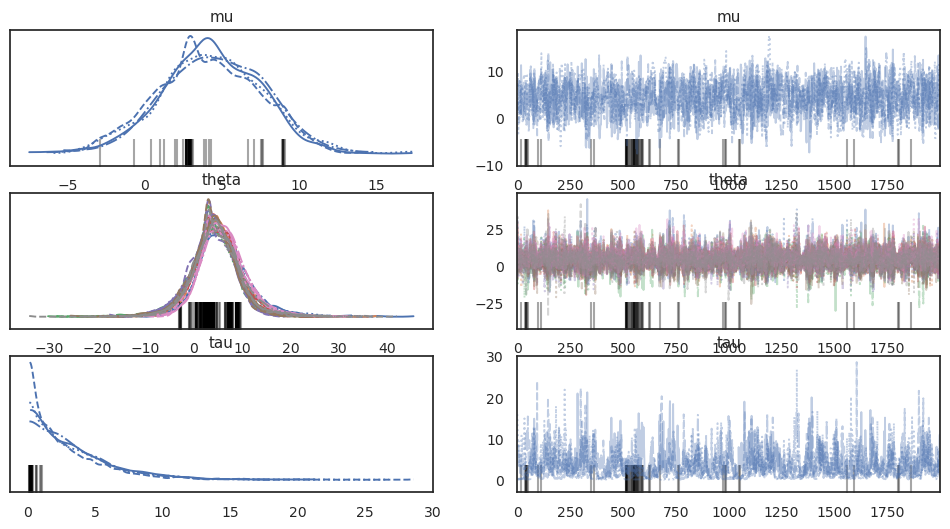

In [10]:
with centered_eight:
    az.plot_trace(samples, combined=False)

Las lineas verticales nos muestran las divergencias o fallos en el algoritmo NUTS. Probemos a reparametrizar el modelo. Utilizaremos la versión no centrada del modelo.

In [11]:
noncentered_eight = pm.Model(coords=coords)

with noncentered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=20)
    nu = pm.Normal('nu', mu=0.0, sigma=1.0, dims="escuela")
    theta = pm.Deterministic('theta', mu+nu*tau,dims="escuela")
    effect = pm.Normal('effect', mu=theta, sigma=df["sd"], observed=df["y"],dims="escuela")

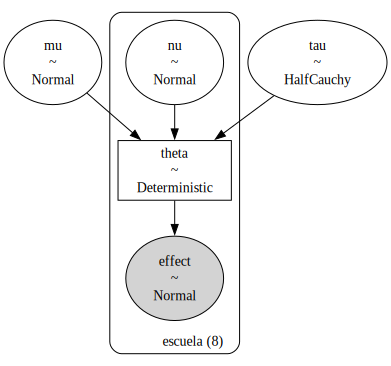

In [12]:
pm.model_to_graphviz(noncentered_eight)

Hacemos la inferencia de nuevo con los parámetros por defecto de PyMC

In [13]:
with noncentered_eight:
    # draw 1000 posterior samples
    samples = pm.sample() # draws=1000, tune=1000,cores=None (default in the system)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


Vemos que las divergencias son ahora mucho menores, aunque hay unas pocas, por lo tanto aumentamos el target_accept

In [14]:
with noncentered_eight:
    # draw 1000 posterior samples
    samples = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Parece ser que con target_accept=0.95 fue suficiente. Veamos las cadenas y la distribución posterior.

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu        4.178  3.536  -2.750   10.534      0.052    0.042  4679.121   
nu[A]     0.433  0.993  -1.494    2.202      0.014    0.015  4918.109   
nu[B]     0.143  0.888  -1.604    1.747      0.012    0.015  5178.493   
nu[C]    -0.101  0.915  -1.793    1.691      0.012    0.015  5382.217   
nu[D]     0.087  0.890  -1.624    1.746      0.012    0.015  5555.914   
nu[E]    -0.187  0.875  -1.891    1.408      0.012    0.015  5632.157   
nu[F]    -0.095  0.913  -1.798    1.649      0.013    0.015  5290.065   
nu[G]     0.460  0.945  -1.450    2.119      0.015    0.015  4416.927   
nu[H]     0.077  0.938  -1.643    1.871      0.013    0.016  4826.496   
tau       5.627  4.598   0.001   13.672      0.094    0.066  2063.508   
theta[A]  7.770  7.368  -4.844   22.981      0.123    0.095  3868.688   
theta[B]  5.262  5.419  -5.099   15.509      0.074    0.063  5577.024   
theta[C]  3.444  6.589 -10.399   14.442      0.095 

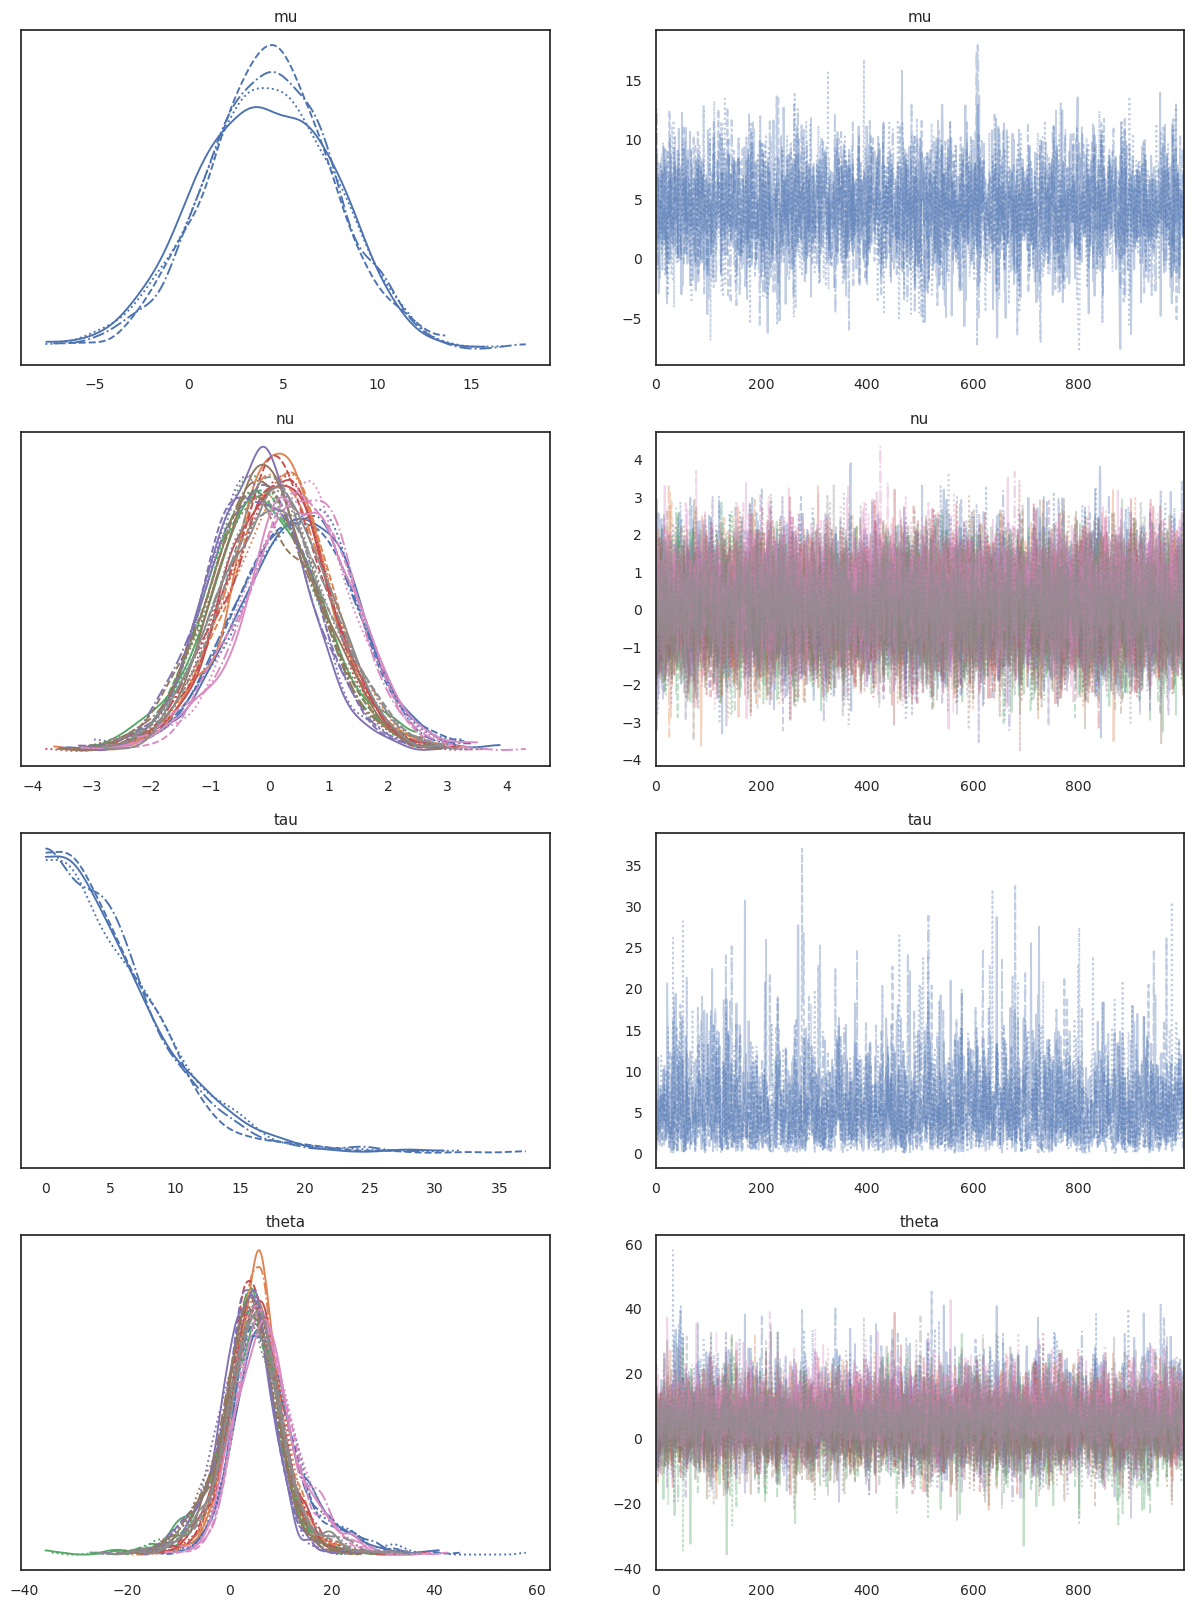

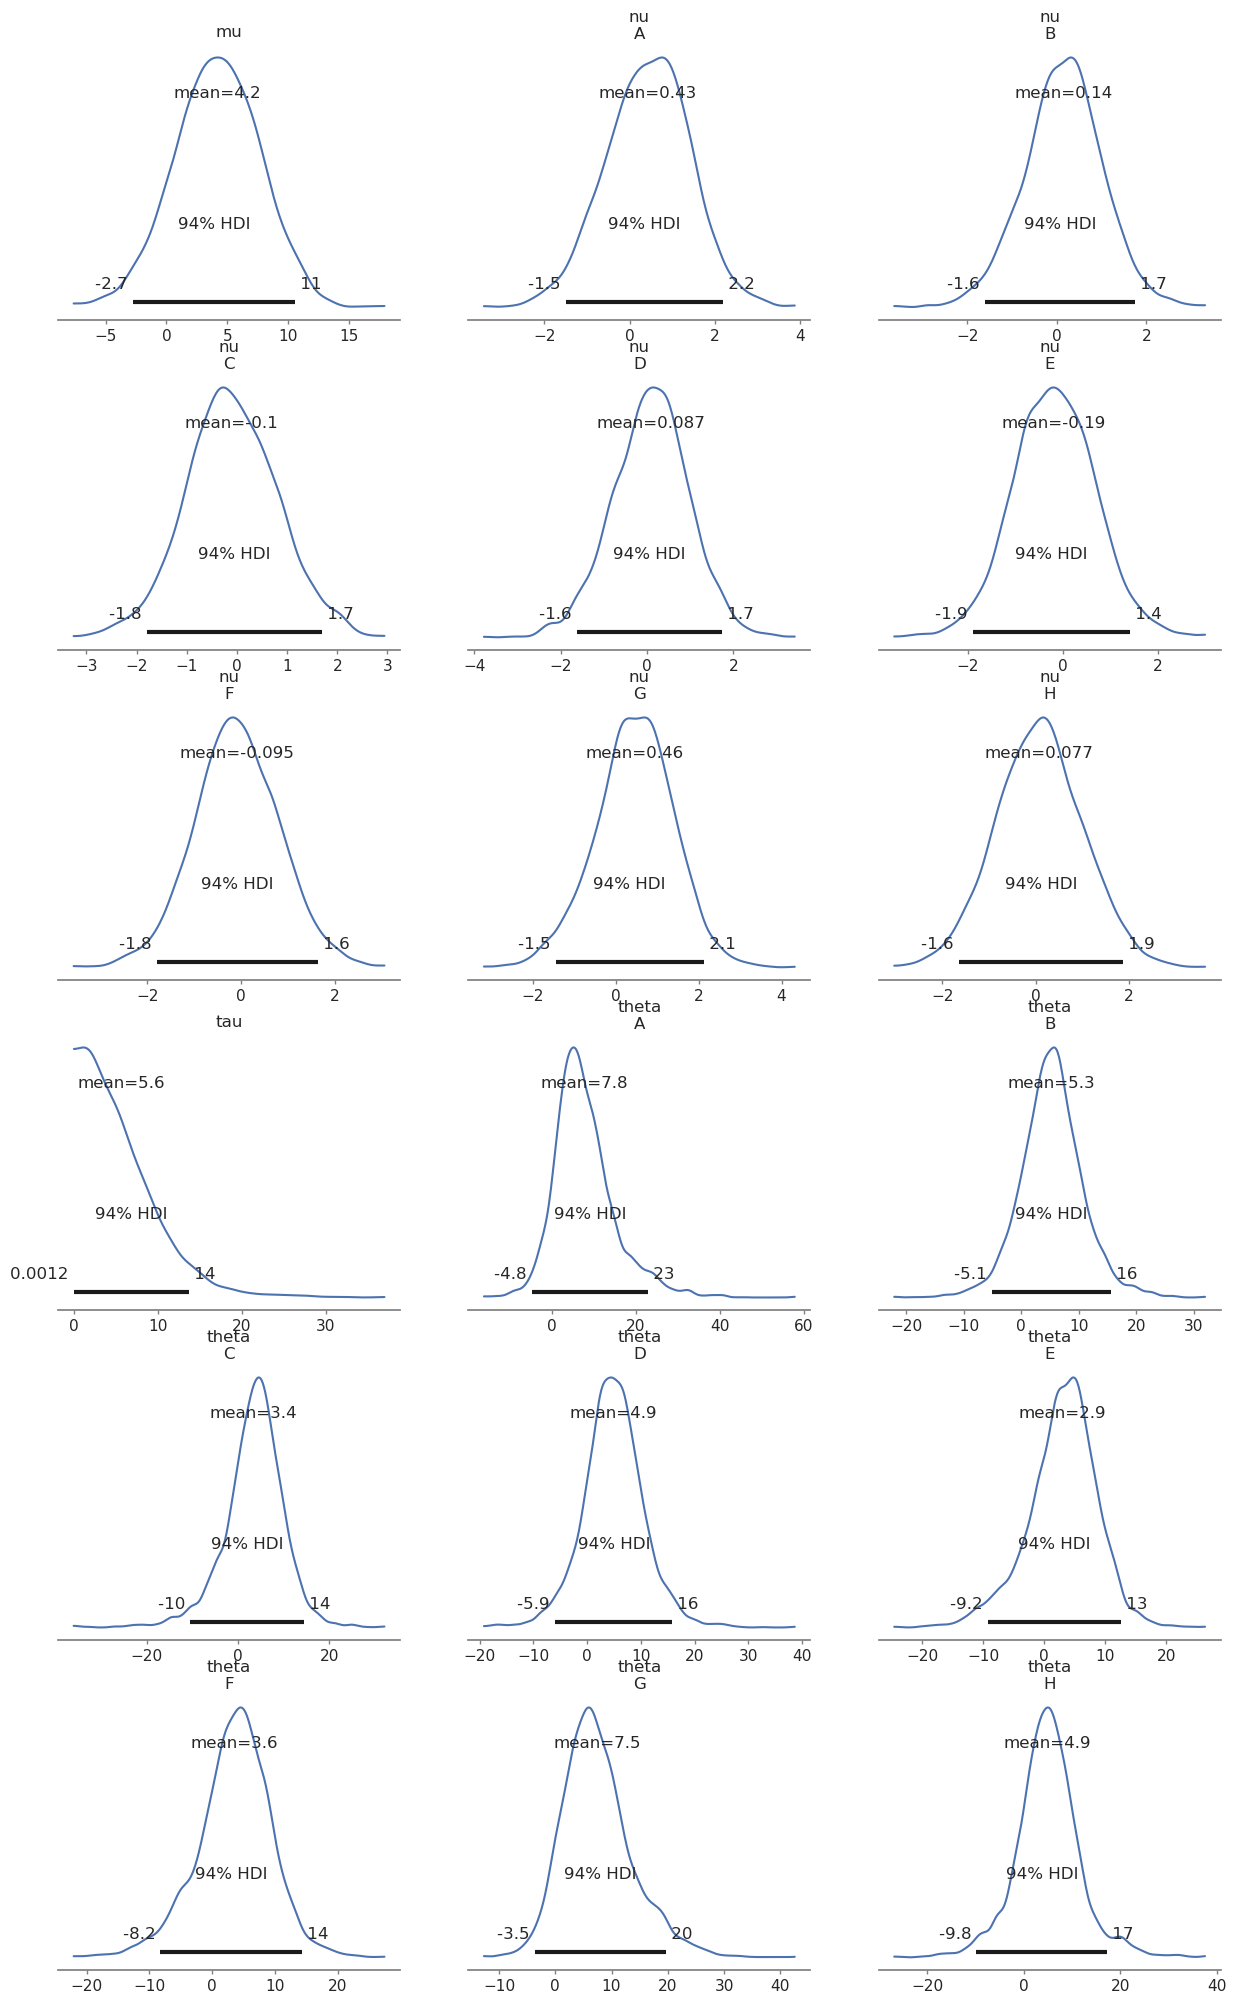

In [15]:
with noncentered_eight:
    print(az.summary(samples, round_to=3))
    az.plot_trace(samples, combined=False,figsize=(15,20))
    az.plot_posterior(samples,figsize=(15,25))
   

Vamos a analizar los resultados del modelo. Recordemos que en nuestro MJB los parámetros de cada escuela $\theta_i$ fueron inferidos como $\theta_i=\mu+\nu_i*\tau$. Si vemos, estos parámetros pueden interpretarse como funciones lineales de $\tau$. Es decir, cuando $\tau$ toma su valor más probable, el cual es cero, obtenemos la media $\mu$ que es global. Sin embargo para valores de $\tau$ mayores y cada vez menos probables se obtienen medias que corresponden a las medias observadas en cada escuela. Para ver esto, pintemos la media de cada escuela, $\theta_i$ como función de $\tau$. 

In [16]:
# Para mayor comodidad convertimos el InferenceData en DataFrame
df_pos = samples.posterior.to_dataframe()
print(df_pos)
df_pos.sort_values(by="tau",inplace=True)

                          mu        nu       tau      theta
chain draw escuela                                         
0     0    A        6.535989  1.555146  2.555723  10.510511
           B        6.535989  2.220132  2.555723  12.210032
           C        6.535989  1.333740  2.555723   9.944659
           D        6.535989  0.359506  2.555723   7.454786
           E        6.535989  2.157122  2.555723  12.048994
...                      ...       ...       ...        ...
3     999  D        5.643020  0.528611  3.257410   7.364923
           E        5.643020  0.229351  3.257410   6.390111
           F        5.643020 -0.977683  3.257410   2.458307
           G        5.643020  0.581328  3.257410   7.536644
           H        5.643020  2.592009  3.257410  14.086257

[32000 rows x 4 columns]


Seleccionamos solo una cadena, para ahorrar tiempo en las gráficas.

In [17]:
df_pos = df_pos.groupby("chain").get_group(0)

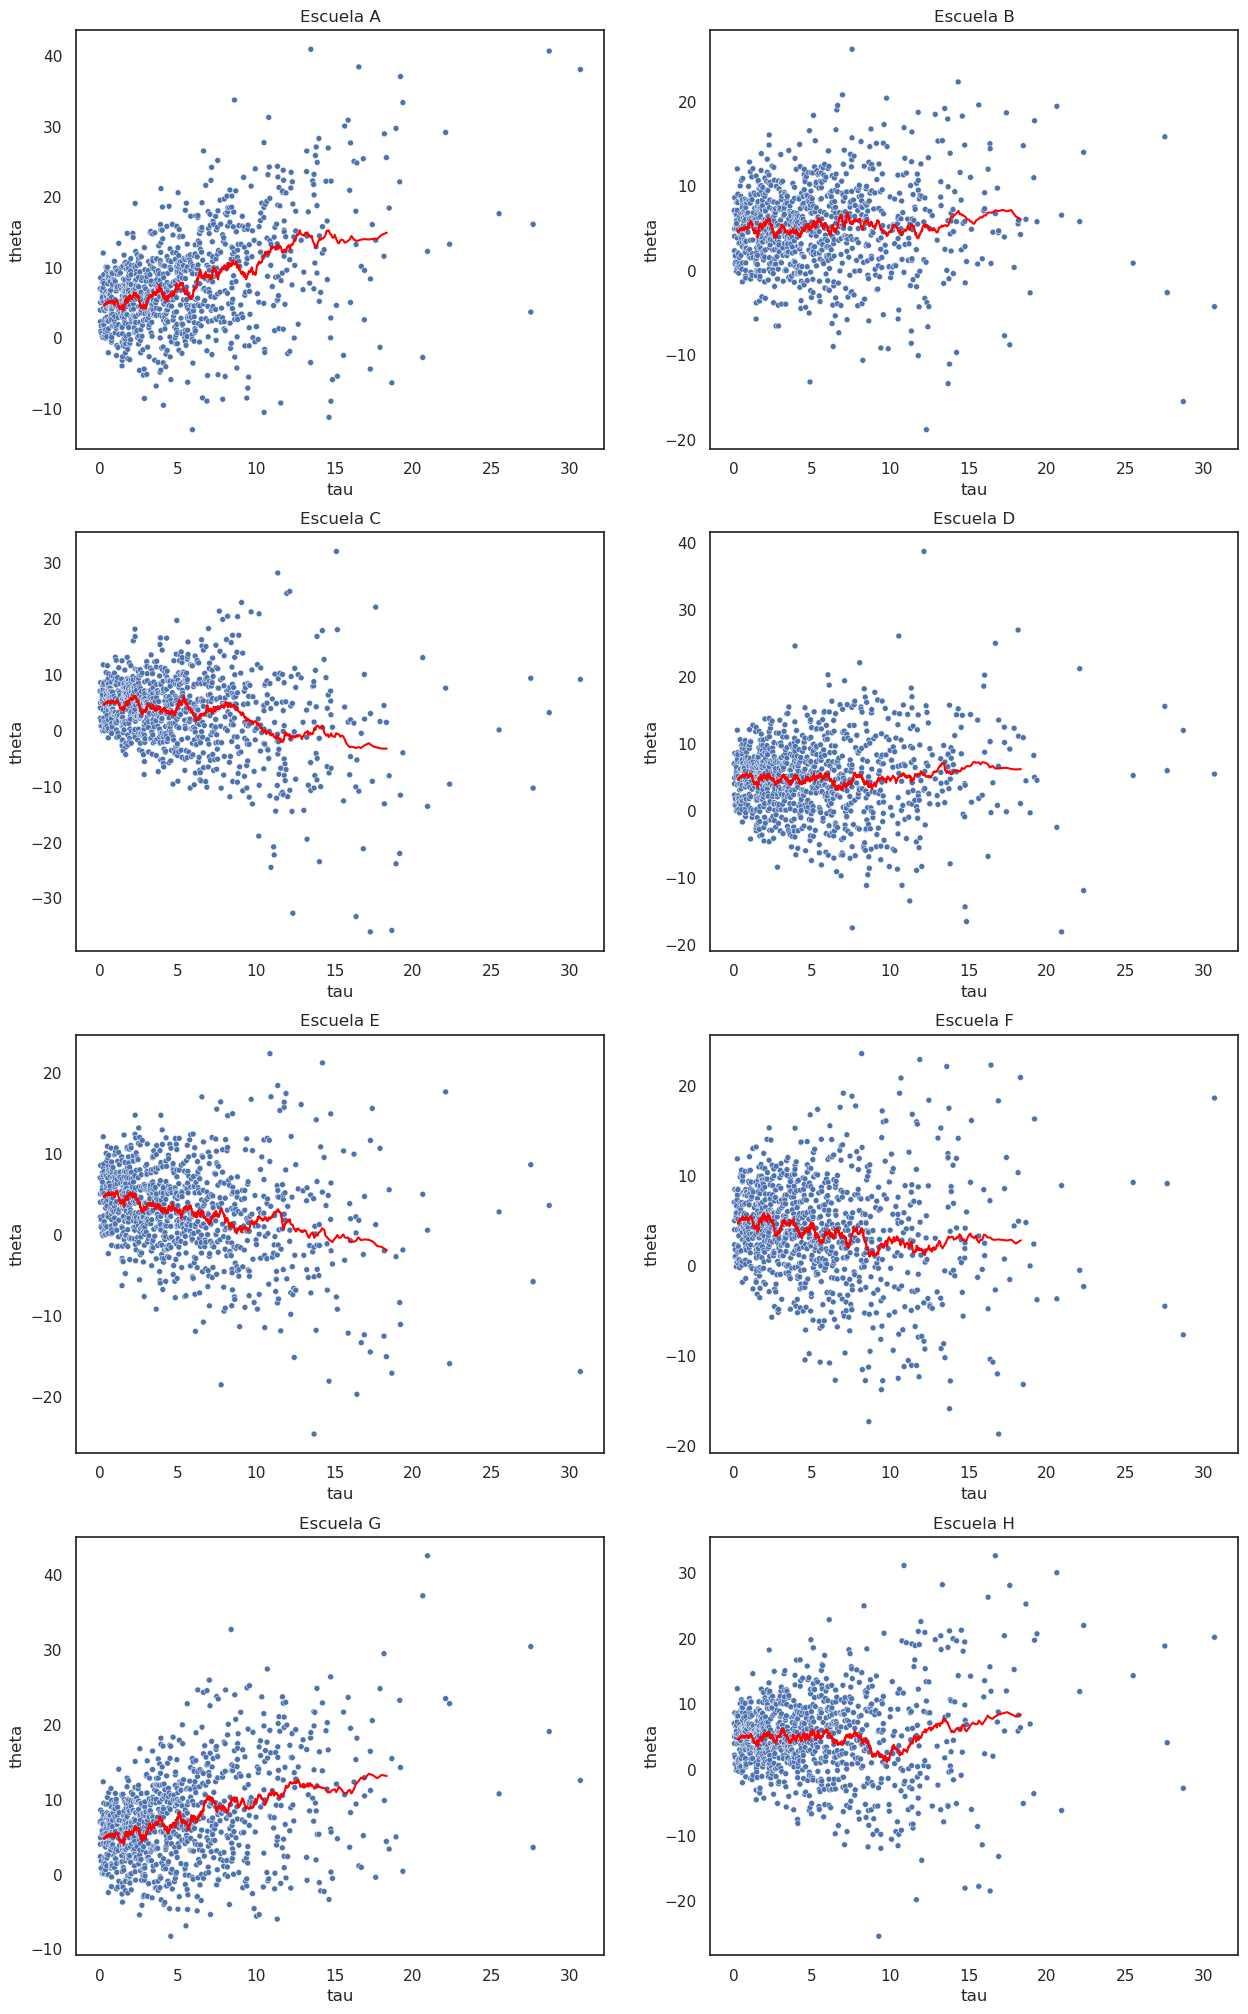

In [18]:
fig, axs = plt.subplots(nrows=4, ncols=2,figsize=(15,25))
dfg = df_pos.groupby(level="escuela")
for ax,e in zip(axs.flatten(),coords["escuela"]):
    df_tmp = dfg.get_group(e)
    ax.set_title("Escuela {0}".format(e))
    sns.scatterplot(data=df_tmp,x="tau",y="theta",
                    ax=ax,size=0.1,legend=False)
    sns.lineplot(data=df_tmp.rolling(window=50).mean(),
             x="tau",y="theta",color="red",ax=ax)

Comprobamos que al aumentar el valor de $\tau$ las medias de cada escuela adquieren sus valores observados. Por ejemplo, en $\tau=25$ la escuela A alcanza $\theta_0\sim20$ y la escuela G $\theta_6\sim15$.

## Conclusiones sobre la inferencia.
Las divergencias son muy útiles para diagnosticar problemas en el modelo. Es importante seguir los consejos dados por el muestreador. Unas cuantas divergencias no son problema pero si su numero no disminuye al aumentar el numero de pasos de ajuste (tunning), entonces lo más probable es que necesitemos reparametrizar nuestro modelo.

## Conclusiones sobre los modelos jerárquicos.
Los MJB nos permiten realizar, de manera simultanea inferencias de los parámetros individuales y globales de nuestros modelos. Son una herramienta poderosa que brinda flexibilidad al momento de realizar inferencias Bayesianas. Sin embargo, como vimos en el problema, su implementación práctica puede ser más compleja que la de un modelo Bayesiano de un solo nivel. 

## Ejercicios

Vamos a trabajar con un conjunto de datos público para analizar la estatura de hombres y mujeres. Descargamos el conjunto de datos del [NCD Risk Factor Collaboration](https://www.ncdrisc.org/data-downloads-height.html) de datos globales (Global data).

### Problema

Usando un modelo jerárquico Bayesiano, determina la edad a partir de la cual la diferencia entre la estatura de hombres y mujeres es significativa (i.e. mayor a 2$\sigma$ o 95%). 

Utiliza los datos más cercanos a la fecha de tu nacimiento así como una parametrización centrada.

### Respuesta

In [19]:
data_all = pd.read_csv("datasets/NCD_RisC_Lancet_2020_height_child_adolescent_global.csv")
print(data_all)

        Sex  Year  Age group  Mean height  \
0      Boys  1985          5   105.649052   
1      Boys  1985          6   111.635352   
2      Boys  1985          7   117.189491   
3      Boys  1985          8   122.438103   
4      Boys  1985          9   127.499794   
...     ...   ...        ...          ...   
1045  Girls  2019         15   156.693073   
1046  Girls  2019         16   157.567922   
1047  Girls  2019         17   158.026195   
1048  Girls  2019         18   158.304538   
1049  Girls  2019         19   158.638269   

      Mean height lower 95% uncertainty interval  \
0                                     105.159635   
1                                     111.190655   
2                                     116.778453   
3                                     122.054426   
4                                     127.131517   
...                                          ...   
1045                                  156.451628   
1046                                  157.3

Extraemos los datos específicos para un año en particular. Aprovechamos para renombrar las columnas.

In [20]:
data = data_all.groupby("Year").get_group(1985).drop(
    columns=["Year","Mean height lower 95% uncertainty interval","Mean height upper 95% uncertainty interval"])
data.rename(columns={"Age group":"ages","Mean height":"y","Mean height standard error":"sd_y"},inplace=True)
print(data)

       Sex  ages           y      sd_y
0     Boys     5  105.649052  0.258115
1     Boys     6  111.635352  0.227526
2     Boys     7  117.189491  0.210784
3     Boys     8  122.438103  0.199455
4     Boys     9  127.499794  0.194522
5     Boys    10  132.708099  0.187002
6     Boys    11  137.851397  0.186425
7     Boys    12  143.666854  0.191759
8     Boys    13  150.399508  0.197735
9     Boys    14  156.700319  0.206760
10    Boys    15  161.448063  0.208375
11    Boys    16  164.298832  0.218638
12    Boys    17  166.033274  0.230721
13    Boys    18  167.120177  0.245361
14    Boys    19  168.033587  0.263851
525  Girls     5  105.473062  0.174617
526  Girls     6  111.486208  0.152296
527  Girls     7  117.028141  0.139698
528  Girls     8  122.387488  0.134042
529  Girls     9  127.851593  0.128920
530  Girls    10  133.942130  0.132641
531  Girls    11  140.187826  0.130977
532  Girls    12  145.797559  0.131974
533  Girls    13  149.793448  0.130590
534  Girls    14  152.372

In [21]:
mu_all = data["y"].mean()
sd_all = data["y"].std()
print(mu_all,sd_all)
ages = np.arange(5,20,dtype=np.float32)
data_boys  = data.groupby("Sex").get_group("Boys").drop(columns="Sex").reset_index(drop=True)
data_girls = data.groupby("Sex").get_group("Girls").drop(columns="Sex").reset_index(drop=True)

140.54992613415507 19.637112295774745


Definimos el modelo con una parametrización central.

In [22]:
model_centered = pm.Model(coords={"age": list(np.arange(5,20))})

with model_centered:
    mu  = pm.Normal('mu', mu=mu_all, sigma=2.*sd_all)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_boys  = pm.Normal('theta_boys',  mu=mu, sigma=tau, dims="age")
    theta_girls = pm.Normal('theta_girls', mu=mu, sigma=tau, dims="age")
    
    #----------------------- Likelihood ------------------------------------------------
    y_boys  = pm.Normal('y_boys',  mu=theta_boys,  sigma=data_boys["sd_y"],  observed=data_boys["y"])
    y_girls = pm.Normal('y_girls', mu=theta_girls, sigma=data_girls["sd_y"], observed=data_girls["y"])
    #-----------------------------------------------------------------------------------
    
    #---------------------- Effect size -------------------------------------------------
    effect_size = pm.Deterministic('effect size', 
    (theta_boys-theta_girls)/np.sqrt(0.5*(data_boys["sd_y"]**2 + data_girls["sd_y"]**2)))
    #------------------------------------------------------------------------------------

Pintamos nuestro modelo.

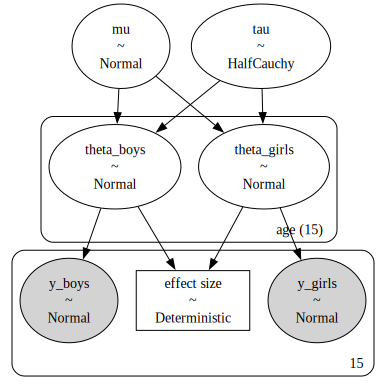

In [23]:
pm.model_to_graphviz(model_centered)

Obtenemos muestras de la distribución posterior utilizando los parámetros por defecto de PyMC.

In [24]:
with model_centered:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta_boys, theta_girls]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Nuestro modelo no tiene divergencias, al parecer no necesitamos ni aumentar el target_accept ni reparametrizar. Veamos los estadísticos y las cadenas de los parámetros globales. 

       mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu   140.60  3.635  133.857  147.527      0.039    0.028  8749.378  2923.756   
tau   19.83  2.655   15.389   25.092      0.031    0.024  9668.676  2945.047   

     r_hat  
mu   1.002  
tau  1.001  


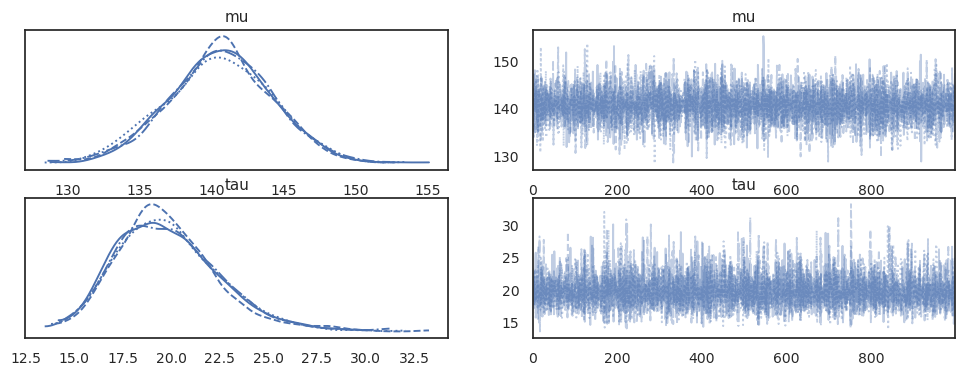

In [25]:
with model_centered:
    print(az.summary(samples, round_to=3,var_names=["mu","tau"]))
    az.plot_trace(samples, combined=False,var_names=["mu","tau"])

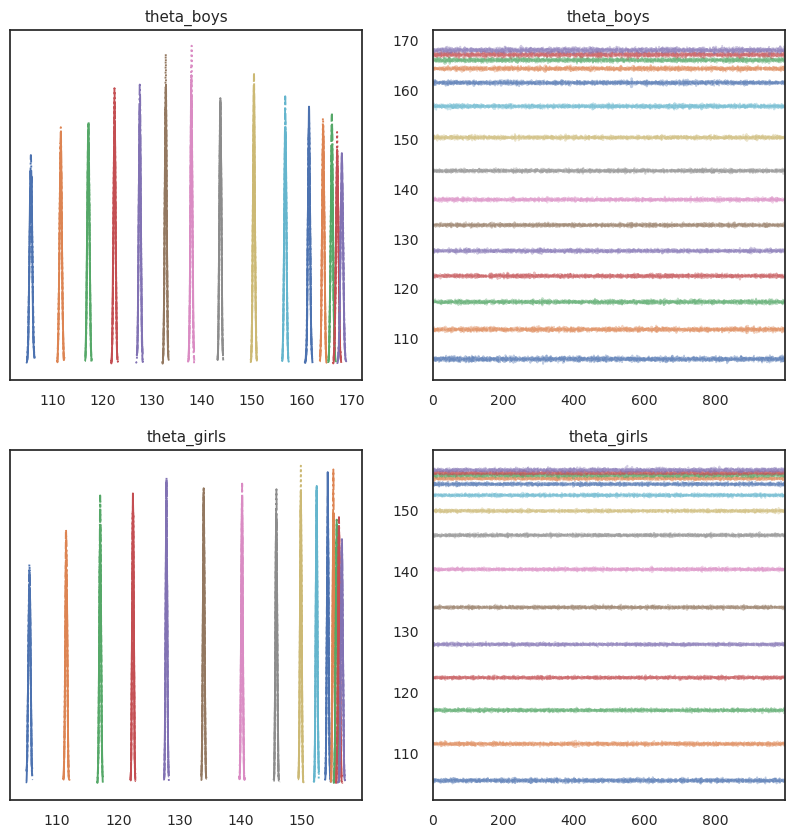

In [26]:
with model_centered:
    az.plot_trace(samples, combined=False,var_names=["theta_boys","theta_girls"],figsize=(10,10))

Pintamos la d de Cohen de manera simultanea para mejorar la visualización.

In [27]:
#----------Extrae el effecto del tamaño --------------
df_pos = samples.posterior.to_dataframe()
print(df_pos)
dfg = df_pos.groupby(level=["age","effect size_dim_0"])
dfs = []
for i,j in enumerate(range(5,20)):
    df = dfg.get_group((j,i))
    tmp=pd.DataFrame(data={
        "effect size":df["effect size"],
        "age":j})
    dfs.append(tmp)
dfs = pd.concat(dfs,ignore_index=True)
#-------------------------------------------------------
print(dfs)

                                          mu  theta_boys  theta_girls  \
chain draw age effect size_dim_0                                        
0     0    5   0                  139.993736  105.508546   105.253677   
               1                  139.993736  105.508546   105.253677   
               2                  139.993736  105.508546   105.253677   
               3                  139.993736  105.508546   105.253677   
               4                  139.993736  105.508546   105.253677   
...                                      ...         ...          ...   
3     999  19  10                 141.111177  167.791509   156.616647   
               11                 141.111177  167.791509   156.616647   
               12                 141.111177  167.791509   156.616647   
               13                 141.111177  167.791509   156.616647   
               14                 141.111177  167.791509   156.616647   

                                        tau  effec

/home/jolivares/anaconda3/envs/ceura/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jolivares/anaconda3/envs/ceura/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jolivares/anaconda3/envs/ceura/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jolivares/anaconda3/envs/ceura/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decoration

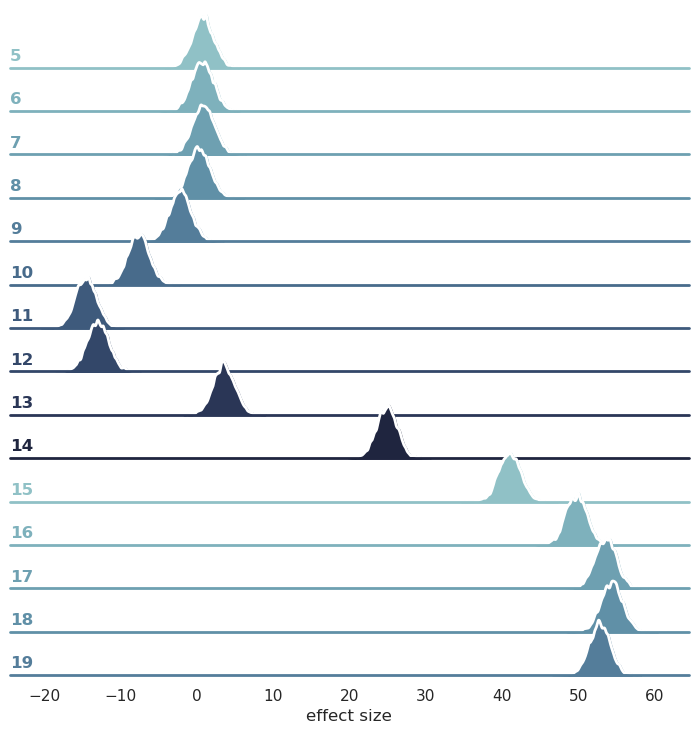

In [28]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(dfs, row="age", hue="age", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "effect size",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "effect size", clip_on=False, color="w", lw=2,bw_adjust=0.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "effect size")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Ahora pintamos la distribución posterior con un hdi del 95%. Desafortunadamente las variables del modelo no vienen con los nombres de las edades, por lo que tendremos que contar.

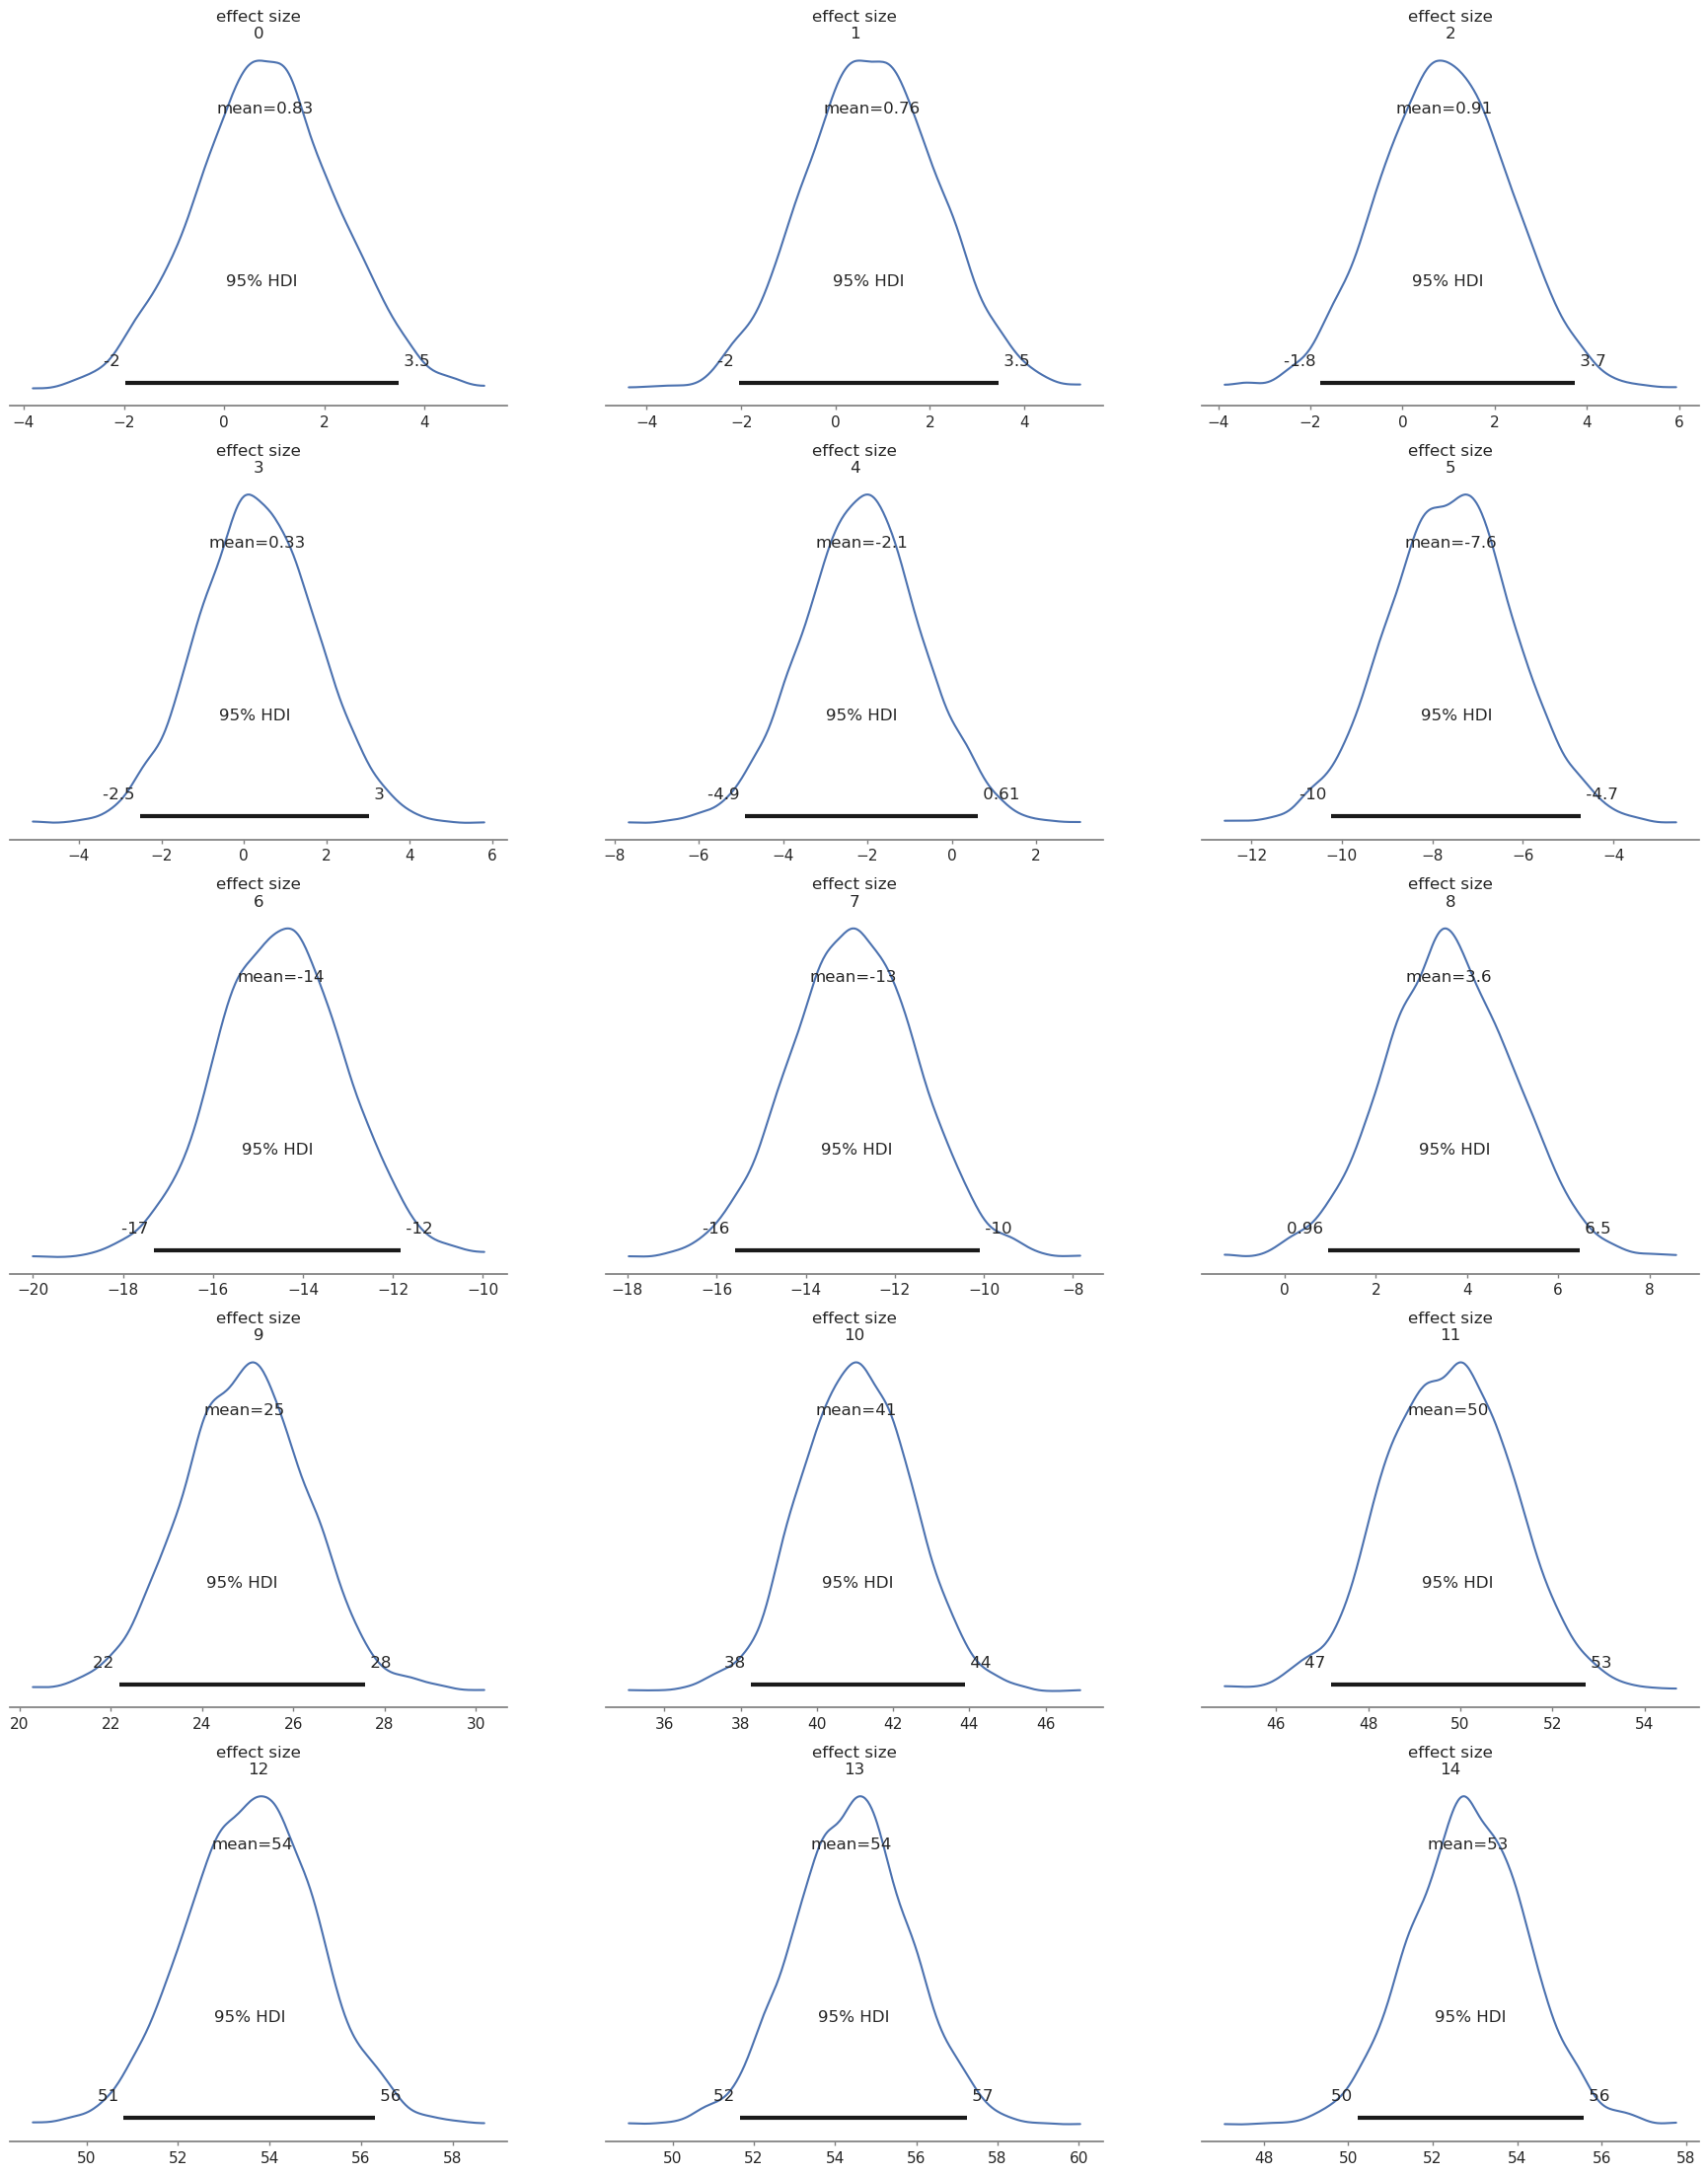

In [29]:
with model_centered:
    az.plot_posterior(samples,var_names=["effect size"],hdi_prob=0.95)

La respuesta a nuestra pregunta es que a partir de los 10 años, la diferencia entre los hombres y las mujeres es significativa (i.e., cero no esta en el HDI de 95%). Además aprendemos que a las edades de 10, 11 y 12 años, las mujeres son significativamente más altas que los hombres, y no es hasta los 13 años que los hombres son significativamente más altos que las mujeres.

### Preguntas
1. ¿Las conclusiones anteriores se mantienen para los datos de la fecha que escogiste?
2. Reflexiona. ¿Por qué en este caso no fue necesario reparametrizar el modelo? Compara los datos de hombres o mujeres con los del ejemplo de las ocho escuelas. ¿Qué diferencias observas? ¿En que casos crees que es necesario reparametrizar los modelos?
3. ¿Qué tan sensible es nuestro modelo a los valores de sus hiperparámetros? Cambia los valores de los hiperparámetros. Si observas que los resultados son sensibles a los valores de los hiperparámetros, ¿Qué opción preferirías?: a) utilizar unos hiperparámetros que resulten en priors menos informativos, o b) aumentar un nivel o jerarquía al modelo. ¿Por qué? Argumenta

### En caso de que te quedarás con ganas de hacer otro ejercicio
* Invierte el orden de elección de las variables, es decir ahora elige una edad e infiere el cambio de estatura en función de la fecha de nacimiento.

Si tienes interés en los patrones de cambio espacio temporal de la estatura de los humanos a nivel mundial, echa un ojo a [ourworldindata](https://ourworldindata.org/human-height), donde podrás descargar conjuntos de datos y explorar resultados interesantes. 